#### 패키지 Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import GRU, Dense

#### 전역변수 설정

In [2]:
trainGraphTitle = "Train Data"
testGraphTitle = "Test Data"
loss = "mse" # mse

resultComment = "Best Parameter Candidate 4"
fileSavePath = "./result/Etc/Best Parameter 4"
depth = "SimpleGRU" # SimpleGRU, DeepGRU

# 변수 "" 가 Default
hiddenState = 64 # units: 32 "64" 256
timeStep = 20 # input_length 10 "20" 40
activation = "tanh" # "tanh" sigmoid
epochs = 100 # 50 "100" 200
batchSize = 64 # 32 "64" 256
dataSetYear = 40 # 5 "10" 40
optimizer = "adam" # "adam" sgd

hiddenState = 32 
timeStep = 10 
activation = "tanh" 
epochs = 100
batchSize = 32 
dataSetYear = 40 
optimizer = "adam" 

#### Pandas Setting

In [3]:
pd.set_option('display.max_rows', None) # row 생략 없이 출력
pd.set_option('display.max_columns', None) # col 생략 없이 출력

#### Data Load

In [4]:
apple = pd.read_csv("Apple_5Y.csv")

if dataSetYear == 10:
    apple = pd.read_csv("Apple_10Y.csv")
elif dataSetYear == 40:
    apple = pd.read_csv("Apple_Whole_Period.csv")

#### Describe 확인

In [5]:
apple.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10602.000000,10602.000000,10602.000000,10602.000000,10602.000000,1.060200e+04
mean,16.470998,16.658052,16.284922,16.477925,15.807495,3.276539e+08
std,35.131697,35.556418,34.715065,35.150839,34.824451,3.378635e+08
min,0.049665,0.049665,0.049107,0.049107,0.038213,0.000000e+00
25%,0.287338,0.294643,0.280759,0.287338,0.237548,1.213772e+08
50%,0.486607,0.493304,0.477679,0.486049,0.402768,2.146984e+08
75%,16.130179,16.309196,15.966607,16.095179,13.919097,4.067266e+08
max,182.630005,182.940002,179.119995,182.009995,180.959747,7.421641e+09


#### trainData, testData 가공하는 함수

In [6]:
def transformData(data: [[float]]) -> ([[[float]]], [[float]], [[[float]]], [[float]]):
    # 날짜 제외
    data = data.drop(columns=["Date"])

    # 데이터 0~1로 정규화
    sc = MinMaxScaler(feature_range=(0, 1))
    sc.fit(data)
    scaledData = sc.transform(data)

    # 데이터 분리 test: 200개와 나머지
    trainSet = scaledData[ : -200]
    testSet = scaledData[-200 : ]

    # trainX, trainY, testX, testY 분리
    def parsingData(dataSet: [[float]]) -> ([[[float]]], [[float]]):
        dataX, dataY = [], []
        for index in range(len(dataSet) - timeStep):
            temp = []
            for step in range(timeStep):
                temp.append(dataSet[index + step])
            dataX.append(temp)
            dataY.append(dataSet[index + timeStep])

        return np.array(dataX), np.array(dataY)

    trainDataX, trainDataY = parsingData(trainSet)
    testDataX, testDataY = parsingData(testSet)

    return trainDataX, trainDataY, testDataX, testDataY

#### Data Parsing

In [28]:
trainX, trainY, testX, testY = transformData(apple)

#### Model Implementation

In [10]:
model = Sequential()

if depth == "SimpleGRU":
    model.add(
        GRU(
            units = hiddenState,
            input_length = trainX.shape[1],
            input_dim = trainX.shape[2],
            activation = activation,
            return_sequences = True
        )
    )
    model.add(
        GRU(
            units = hiddenState,
            activation = activation
        )
    )
    model.add(Dense(6))
    
elif depth == "DeepGRU":
    model.add(
    GRU(
        units = hiddenState,
        input_length = trainX.shape[1],
        input_dim = trainX.shape[2],
        activation = activation
        )
    )
    model.add(Dense(6))

model.summary()

Metal device set to: Apple M1


2023-01-04 17:25:31.116949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-04 17:25:31.117063: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            13824     
                                                                 
 gru_1 (GRU)                 (None, 64)                24960     
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 39,174
Trainable params: 39,174
Non-trainable params: 0
_________________________________________________________________


#### Model Complie

In [11]:
model.compile(
    loss = loss,
    optimizer = optimizer,
    metrics = ["mae"]
)

#### Model Training

In [12]:
fitStartTime = time.time()
history = model.fit(
    trainX,
    trainY,
    epochs = epochs,
    batch_size = batchSize
)
fitEndTime = time.time()

Epoch 1/100


2023-01-04 17:25:31.434066: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-04 17:25:32.519411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:25:32.687150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:25:32.757957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:25:32.867854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  4/163 [..............................] - ETA: 3s - loss: 0.0214 - mae: 0.0626  

2023-01-04 17:25:33.094158: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


163/163 [==============================] - 5s 17ms/step - loss: 0.0010 - mae: 0.0124
Epoch 2/100
163/163 [==============================] - 3s 16ms/step - loss: 2.3171e-04 - mae: 0.0062
Epoch 3/100
163/163 [==============================] - 3s 17ms/step - loss: 2.6177e-04 - mae: 0.0066
Epoch 4/100
163/163 [==============================] - 3s 17ms/step - loss: 1.7382e-04 - mae: 0.0051
Epoch 5/100
163/163 [==============================] - 3s 17ms/step - loss: 1.7171e-04 - mae: 0.0053
Epoch 6/100
163/163 [==============================] - 3s 17ms/step - loss: 1.7270e-04 - mae: 0.0055
Epoch 7/100
163/163 [==============================] - 3s 18ms/step - loss: 1.6517e-04 - mae: 0.0052
Epoch 8/100
163/163 [==============================] - 3s 18ms/step - loss: 1.6568e-04 - mae: 0.0054
Epoch 9/100
163/163 [==============================] - 3s 17ms/step - loss: 1.6011e-04 - mae: 0.0053
Epoch 10/100
163/163 [==============================] - 3s 17ms/step - loss: 1.5915e-04 - mae: 0.0053
Epoch

163/163 [==============================] - 3s 18ms/step - loss: 2.0299e-04 - mae: 0.0079
Epoch 82/100
163/163 [==============================] - 3s 18ms/step - loss: 2.0010e-04 - mae: 0.0076
Epoch 83/100
163/163 [==============================] - 3s 18ms/step - loss: 2.0502e-04 - mae: 0.0076
Epoch 84/100
163/163 [==============================] - 3s 18ms/step - loss: 4.2180e-04 - mae: 0.0117
Epoch 85/100
163/163 [==============================] - 3s 18ms/step - loss: 1.9124e-04 - mae: 0.0074
Epoch 86/100
163/163 [==============================] - 3s 18ms/step - loss: 1.8084e-04 - mae: 0.0071
Epoch 87/100
163/163 [==============================] - 3s 18ms/step - loss: 1.7052e-04 - mae: 0.0066
Epoch 88/100
163/163 [==============================] - 3s 18ms/step - loss: 1.6601e-04 - mae: 0.0063
Epoch 89/100
163/163 [==============================] - 3s 18ms/step - loss: 1.7085e-04 - mae: 0.0066
Epoch 90/100
163/163 [==============================] - 3s 18ms/step - loss: 1.6551e-04 - mae: 

#### 시간 및 평가 기록

In [13]:
fitTime = fitEndTime - fitStartTime
score = model.evaluate(testX, testY)

f = open("result.txt", "a")
f.write(f"{resultComment}\n모델 학습 시간: {fitTime:.3} sec\n평가 손실: {score[0]}\n\n")
f.close()

1/6 [====>.........................] - ETA: 2s - loss: 0.0016 - mae: 0.0339

2023-01-04 17:30:30.361508: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:30:30.423265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:30:30.476190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 1s 27ms/step - loss: 0.0012 - mae: 0.0285


In [14]:
f"모델 학습 시간: {fitTime:.3} sec"

'모델 학습 시간: 2.99e+02 sec'

In [15]:
f"평가 손실: {score[0]}"

'평가 손실: 0.0012201477074995637'

#### 예측

In [16]:
trainPrediction = model.predict(trainX)
testPrediction = model.predict(testX)

  1/325 [..............................] - ETA: 1:53

2023-01-04 17:30:30.912823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:30:30.962150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-01-04 17:30:31.017733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


6/6 [==============================] - 0s 21ms/step


#### 그래프

#### Loss

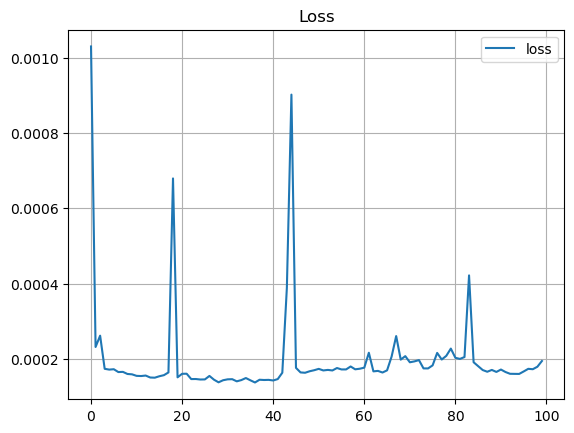

In [17]:
loss = history.history["loss"]
plt.title("Loss")
plt.plot(loss, label="loss")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Loss.png")
plt.legend()
plt.show()

Train Data Graph

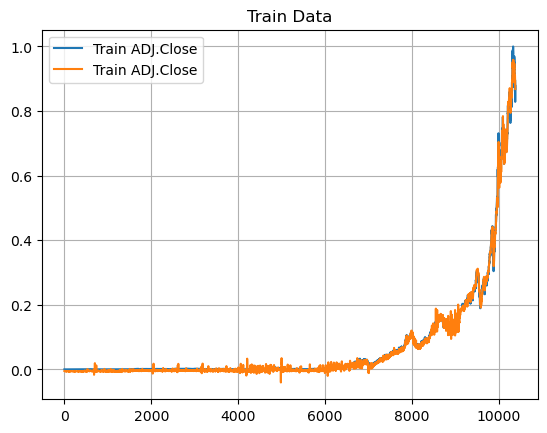

In [18]:
plt.title(trainGraphTitle)
plt.plot(trainY[:, 4], label="Train ADJ.Close")
plt.plot(trainPrediction[:, 4], label="Train ADJ.Close")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Train.png")
plt.legend()
plt.show()

Test Data Graph

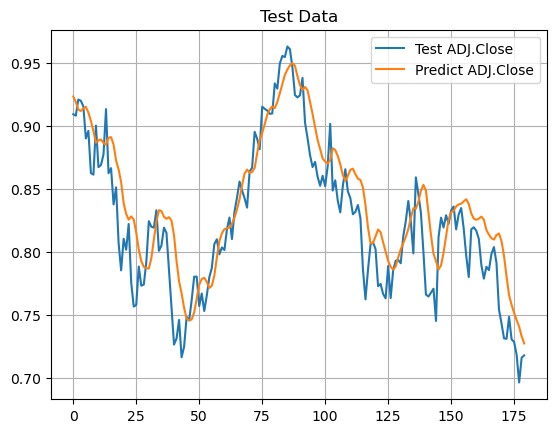

In [19]:
plt.title(testGraphTitle)
plt.plot(testY[:, 4], label="Test ADJ.Close")
plt.plot(testPrediction[:, 4], label="Predict ADJ.Close")
plt.grid(True)
plt.savefig(f"{fileSavePath}/Test.png")
plt.legend()
plt.show()

#### 30일 후 예측

In [29]:
for _ in range(30):
    nextPredict = model.predict(testX)
    newData = nextPredict[-timeStep:]
    newData = np.reshape(newData, (1, newData.shape[0], newData.shape[1]))
    testX = np.append(testX, newData, axis = 0)

6/6 [==============================] - 0s 12ms/step
[[0.8403915  0.8443234  0.84217024 0.8342135  0.8254766  0.03026134]
 [0.84284997 0.8448003  0.8453424  0.8355465  0.8264255  0.03075611]
 [0.8436441  0.8472087  0.8471992  0.83553416 0.8280241  0.03208669]
 [0.8371966  0.8414461  0.8445169  0.8292775  0.8256539  0.03549832]
 [0.8262433  0.83208233 0.83535564 0.8175684  0.8174654  0.04284683]
 [0.8238655  0.83105034 0.8314996  0.8150976  0.8136973  0.04045307]
 [0.8218058  0.82774967 0.8290998  0.81479865 0.81087095 0.03872437]
 [0.8228381  0.82758397 0.82825434 0.81652683 0.80978304 0.03652406]
 [0.8277861  0.8326668  0.8319613  0.82276505 0.8134398  0.03585489]
 [0.8245631  0.8270217  0.8312545  0.8215079  0.81466776 0.0363131 ]
 [0.81476253 0.8151545  0.8214547  0.8095197  0.8086212  0.04346621]
 [0.80130017 0.8029841  0.8085524  0.7934138  0.796851   0.04929115]
 [0.7846263  0.7895687  0.7940756  0.77814883 0.7805055  0.04768753]
 [0.7719128  0.77637416 0.7812048  0.76611406 0.765

6/6 [==============================] - 0s 10ms/step
[[0.8436441  0.8472087  0.8471992  0.83553416 0.8280241  0.03208669]
 [0.8371966  0.8414461  0.8445169  0.8292775  0.8256539  0.03549832]
 [0.8262433  0.83208233 0.83535564 0.8175684  0.8174654  0.04284683]
 [0.8238655  0.83105034 0.8314996  0.8150976  0.8136973  0.04045307]
 [0.8218058  0.82774967 0.8290998  0.81479865 0.81087095 0.03872437]
 [0.8228381  0.82758397 0.82825434 0.81652683 0.80978304 0.03652406]
 [0.8277861  0.8326668  0.8319613  0.82276505 0.8134398  0.03585489]
 [0.8245631  0.8270217  0.8312545  0.8215079  0.81466776 0.0363131 ]
 [0.81476253 0.8151545  0.8214547  0.8095197  0.8086212  0.04346621]
 [0.80130017 0.8029841  0.8085524  0.7934138  0.796851   0.04929115]
 [0.7846263  0.7895687  0.7940756  0.77814883 0.7805055  0.04768753]
 [0.7719128  0.77637416 0.7812048  0.76611406 0.7658174  0.04735657]
 [0.7677829  0.7727675  0.77525663 0.76390517 0.7579993  0.03921698]
 [0.75978285 0.7614837  0.76887625 0.7587947  0.751

6/6 [==============================] - 0s 9ms/step
[[0.8262433  0.83208233 0.83535564 0.8175684  0.8174654  0.04284683]
 [0.8238655  0.83105034 0.8314996  0.8150976  0.8136973  0.04045307]
 [0.8218058  0.82774967 0.8290998  0.81479865 0.81087095 0.03872437]
 [0.8228381  0.82758397 0.82825434 0.81652683 0.80978304 0.03652406]
 [0.8277861  0.8326668  0.8319613  0.82276505 0.8134398  0.03585489]
 [0.8245631  0.8270217  0.8312545  0.8215079  0.81466776 0.0363131 ]
 [0.81476253 0.8151545  0.8214547  0.8095197  0.8086212  0.04346621]
 [0.80130017 0.8029841  0.8085524  0.7934138  0.796851   0.04929115]
 [0.7846263  0.7895687  0.7940756  0.77814883 0.7805055  0.04768753]
 [0.7719128  0.77637416 0.7812048  0.76611406 0.7658174  0.04735657]
 [0.7677829  0.7727675  0.77525663 0.76390517 0.7579993  0.03921698]
 [0.75978285 0.7614837  0.76887625 0.7587947  0.75174016 0.03545781]
 [0.75399446 0.7543329  0.7616746  0.7524759  0.7459653  0.03382749]
 [0.7464429  0.74694806 0.75507355 0.7453755  0.7406

6/6 [==============================] - 0s 10ms/step
[[0.8218058  0.82774967 0.8290998  0.81479865 0.81087095 0.03872437]
 [0.8228381  0.82758397 0.82825434 0.81652683 0.80978304 0.03652406]
 [0.8277861  0.8326668  0.8319613  0.82276505 0.8134398  0.03585489]
 [0.8245631  0.8270217  0.8312545  0.8215079  0.81466776 0.0363131 ]
 [0.81476253 0.8151545  0.8214547  0.8095197  0.8086212  0.04346621]
 [0.80130017 0.8029841  0.8085524  0.7934138  0.796851   0.04929115]
 [0.7846263  0.7895687  0.7940756  0.77814883 0.7805055  0.04768753]
 [0.7719128  0.77637416 0.7812048  0.76611406 0.7658174  0.04735657]
 [0.7677829  0.7727675  0.77525663 0.76390517 0.7579993  0.03921698]
 [0.75978285 0.7614837  0.76887625 0.7587947  0.75174016 0.03545781]
 [0.75399446 0.7543329  0.7616746  0.7524759  0.7459653  0.03382749]
 [0.7464429  0.74694806 0.75507355 0.7453755  0.740676   0.03278223]
 [0.73757964 0.7358834  0.7464435  0.73679537 0.73302656 0.03126724]
 [0.7362405  0.7345042  0.7416346  0.7344433  0.727

6/6 [==============================] - 0s 9ms/step
[[0.8277861  0.8326668  0.8319613  0.82276505 0.8134398  0.03585489]
 [0.8245631  0.8270217  0.8312545  0.8215079  0.81466776 0.0363131 ]
 [0.81476253 0.8151545  0.8214547  0.8095197  0.8086212  0.04346621]
 [0.80130017 0.8029841  0.8085524  0.7934138  0.796851   0.04929115]
 [0.7846263  0.7895687  0.7940756  0.77814883 0.7805055  0.04768753]
 [0.7719128  0.77637416 0.7812048  0.76611406 0.7658174  0.04735657]
 [0.7677829  0.7727675  0.77525663 0.76390517 0.7579993  0.03921698]
 [0.75978285 0.7614837  0.76887625 0.7587947  0.75174016 0.03545781]
 [0.75399446 0.7543329  0.7616746  0.7524759  0.7459653  0.03382749]
 [0.7464429  0.74694806 0.75507355 0.7453755  0.740676   0.03278223]
 [0.73757964 0.7358834  0.7464435  0.73679537 0.73302656 0.03126724]
 [0.7362405  0.7345042  0.7416346  0.7344433  0.727451   0.02481908]
 [0.74747777 0.7561544  0.7635535  0.742105   0.7407597  0.06663382]
 [0.75124604 0.75492704 0.763144   0.7413625  0.7405

6/6 [==============================] - 0s 9ms/step
[[0.81476253 0.8151545  0.8214547  0.8095197  0.8086212  0.04346621]
 [0.80130017 0.8029841  0.8085524  0.7934138  0.796851   0.04929115]
 [0.7846263  0.7895687  0.7940756  0.77814883 0.7805055  0.04768753]
 [0.7719128  0.77637416 0.7812048  0.76611406 0.7658174  0.04735657]
 [0.7677829  0.7727675  0.77525663 0.76390517 0.7579993  0.03921698]
 [0.75978285 0.7614837  0.76887625 0.7587947  0.75174016 0.03545781]
 [0.75399446 0.7543329  0.7616746  0.7524759  0.7459653  0.03382749]
 [0.7464429  0.74694806 0.75507355 0.7453755  0.740676   0.03278223]
 [0.73757964 0.7358834  0.7464435  0.73679537 0.73302656 0.03126724]
 [0.7362405  0.7345042  0.7416346  0.7344433  0.727451   0.02481908]
 [0.74747777 0.7561544  0.7635535  0.742105   0.7407597  0.06663382]
 [0.75124604 0.75492704 0.763144   0.7413625  0.74056035 0.07347912]
 [0.7506418  0.7518771  0.7610569  0.7401064  0.73863965 0.06966252]
 [0.74822587 0.75016886 0.7586751  0.73681766 0.7353

6/6 [==============================] - 0s 8ms/step
[[0.7846263  0.7895687  0.7940756  0.77814883 0.7805055  0.04768753]
 [0.7719128  0.77637416 0.7812048  0.76611406 0.7658174  0.04735657]
 [0.7677829  0.7727675  0.77525663 0.76390517 0.7579993  0.03921698]
 [0.75978285 0.7614837  0.76887625 0.7587947  0.75174016 0.03545781]
 [0.75399446 0.7543329  0.7616746  0.7524759  0.7459653  0.03382749]
 [0.7464429  0.74694806 0.75507355 0.7453755  0.740676   0.03278223]
 [0.73757964 0.7358834  0.7464435  0.73679537 0.73302656 0.03126724]
 [0.7362405  0.7345042  0.7416346  0.7344433  0.727451   0.02481908]
 [0.74747777 0.7561544  0.7635535  0.742105   0.7407597  0.06663382]
 [0.75124604 0.75492704 0.763144   0.7413625  0.74056035 0.07347912]
 [0.7506418  0.7518771  0.7610569  0.7401064  0.73863965 0.06966252]
 [0.74822587 0.75016886 0.7586751  0.73681766 0.7353965  0.07842927]
 [0.73521394 0.741224   0.7530017  0.72641915 0.72972816 0.09132478]
 [0.71699333 0.72582084 0.7418425  0.7126553  0.7212

7/7 [==============================] - 0s 9ms/step
[[0.7677829  0.7727675  0.77525663 0.76390517 0.7579993  0.03921698]
 [0.75978285 0.7614837  0.76887625 0.7587947  0.75174016 0.03545781]
 [0.75399446 0.7543329  0.7616746  0.7524759  0.7459653  0.03382749]
 [0.7464429  0.74694806 0.75507355 0.7453755  0.740676   0.03278223]
 [0.73757964 0.7358834  0.7464435  0.73679537 0.73302656 0.03126724]
 [0.7362405  0.7345042  0.7416346  0.7344433  0.727451   0.02481908]
 [0.74747777 0.7561544  0.7635535  0.742105   0.7407597  0.06663382]
 [0.75124604 0.75492704 0.763144   0.7413625  0.74056035 0.07347912]
 [0.7506418  0.7518771  0.7610569  0.7401064  0.73863965 0.06966252]
 [0.74822587 0.75016886 0.7586751  0.73681766 0.7353965  0.07842927]
 [0.73521394 0.741224   0.7530017  0.72641915 0.72972816 0.09132478]
 [0.71699333 0.72582084 0.7418425  0.7126553  0.7212359  0.10727697]
 [0.69821644 0.7066703  0.7261635  0.6960191  0.70991796 0.11895616]
 [0.67838925 0.6866482  0.70806354 0.6762967  0.6950

[[[0.86844145 0.88003739 0.87999172 0.88244727 0.88357867 0.0101885 ]
  [0.8788478  0.89906516 0.89188639 0.90091278 0.90206668 0.0166421 ]
  [0.89527892 0.90928993 0.91003563 0.90860679 0.90976998 0.01290973]
  ...
  [0.9237596  0.92394348 0.92394076 0.91064016 0.91180584 0.0097346 ]
  [0.91998043 0.92853637 0.93030695 0.92113695 0.92231536 0.01068028]
  [0.91652986 0.93493364 0.93103295 0.93619507 0.93739185 0.00951527]]

 [[0.8788478  0.89906516 0.89188639 0.90091278 0.90206668 0.0166421 ]
  [0.89527892 0.90928993 0.91003563 0.90860679 0.90976998 0.01290973]
  [0.906233   0.9260759  0.920646   0.92751196 0.92869816 0.01098571]
  ...
  [0.91998043 0.92853637 0.93030695 0.92113695 0.92231536 0.01068028]
  [0.91652986 0.93493364 0.93103295 0.93619507 0.93739185 0.00951527]
  [0.93422068 0.93619128 0.92137191 0.90811211 0.90927474 0.01014997]]

 [[0.89527892 0.90928993 0.91003563 0.90860679 0.90976998 0.01290973]
  [0.906233   0.9260759  0.920646   0.92751196 0.92869816 0.01098571]
  [0

7/7 [==============================] - 0s 9ms/step
[[0.73757964 0.7358834  0.7464435  0.73679537 0.73302656 0.03126724]
 [0.7362405  0.7345042  0.7416346  0.7344433  0.727451   0.02481908]
 [0.74747777 0.7561544  0.7635535  0.742105   0.7407597  0.06663382]
 [0.75124604 0.75492704 0.763144   0.7413625  0.74056035 0.07347912]
 [0.7506418  0.7518771  0.7610569  0.7401064  0.73863965 0.06966252]
 [0.74822587 0.75016886 0.7586751  0.73681766 0.7353965  0.07842927]
 [0.73521394 0.741224   0.7530017  0.72641915 0.72972816 0.09132478]
 [0.71699333 0.72582084 0.7418425  0.7126553  0.7212359  0.10727697]
 [0.69821644 0.7066703  0.7261635  0.6960191  0.70991796 0.11895616]
 [0.67838925 0.6866482  0.70806354 0.6762967  0.6950732  0.12956455]
 [0.65652955 0.66353166 0.686236   0.6527564  0.6753351  0.14030407]
 [0.6314815  0.6347628  0.6586292  0.6238332  0.6491886  0.15016612]
 [0.6052166  0.6007942  0.624949   0.58997124 0.61708736 0.15876171]
 [0.5801784  0.56404    0.58718807 0.5531378  0.5806

7/7 [==============================] - 0s 9ms/step
[[0.74747777 0.7561544  0.7635535  0.742105   0.7407597  0.06663382]
 [0.75124604 0.75492704 0.763144   0.7413625  0.74056035 0.07347912]
 [0.7506418  0.7518771  0.7610569  0.7401064  0.73863965 0.06966252]
 [0.74822587 0.75016886 0.7586751  0.73681766 0.7353965  0.07842927]
 [0.73521394 0.741224   0.7530017  0.72641915 0.72972816 0.09132478]
 [0.71699333 0.72582084 0.7418425  0.7126553  0.7212359  0.10727697]
 [0.69821644 0.7066703  0.7261635  0.6960191  0.70991796 0.11895616]
 [0.67838925 0.6866482  0.70806354 0.6762967  0.6950732  0.12956455]
 [0.65652955 0.66353166 0.686236   0.6527564  0.6753351  0.14030407]
 [0.6314815  0.6347628  0.6586292  0.6238332  0.6491886  0.15016612]
 [0.6052166  0.6007942  0.624949   0.58997124 0.61708736 0.15876171]
 [0.5801784  0.56404    0.58718807 0.5531378  0.58067906 0.16561058]
 [0.5566486  0.5272572  0.54994786 0.51673996 0.5437242  0.16966584]
 [0.5311978  0.49002254 0.5160394  0.48211068 0.5083

7/7 [==============================] - 0s 9ms/step
[[0.7506418  0.7518771  0.7610569  0.7401064  0.73863965 0.06966252]
 [0.74822587 0.75016886 0.7586751  0.73681766 0.7353965  0.07842927]
 [0.73521394 0.741224   0.7530017  0.72641915 0.72972816 0.09132478]
 [0.71699333 0.72582084 0.7418425  0.7126553  0.7212359  0.10727697]
 [0.69821644 0.7066703  0.7261635  0.6960191  0.70991796 0.11895616]
 [0.67838925 0.6866482  0.70806354 0.6762967  0.6950732  0.12956455]
 [0.65652955 0.66353166 0.686236   0.6527564  0.6753351  0.14030407]
 [0.6314815  0.6347628  0.6586292  0.6238332  0.6491886  0.15016612]
 [0.6052166  0.6007942  0.624949   0.58997124 0.61708736 0.15876171]
 [0.5801784  0.56404    0.58718807 0.5531378  0.58067906 0.16561058]
 [0.5566486  0.5272572  0.54994786 0.51673996 0.5437242  0.16966584]
 [0.5311978  0.49002254 0.5160394  0.48211068 0.50835884 0.16773643]
 [0.50117236 0.45332795 0.48498315 0.4484877  0.4726808  0.16062817]
 [0.4703518  0.42188156 0.45705214 0.418366   0.4383

7/7 [==============================] - 0s 9ms/step
[[ 0.73521394  0.741224    0.7530017   0.72641915  0.72972816  0.09132478]
 [ 0.71699333  0.72582084  0.7418425   0.7126553   0.7212359   0.10727697]
 [ 0.69821644  0.7066703   0.7261635   0.6960191   0.70991796  0.11895616]
 [ 0.67838925  0.6866482   0.70806354  0.6762967   0.6950732   0.12956455]
 [ 0.65652955  0.66353166  0.686236    0.6527564   0.6753351   0.14030407]
 [ 0.6314815   0.6347628   0.6586292   0.6238332   0.6491886   0.15016612]
 [ 0.6052166   0.6007942   0.624949    0.58997124  0.61708736  0.15876171]
 [ 0.5801784   0.56404     0.58718807  0.5531378   0.58067906  0.16561058]
 [ 0.5566486   0.5272572   0.54994786  0.51673996  0.5437242   0.16966584]
 [ 0.5311978   0.49002254  0.5160394   0.48211068  0.50835884  0.16773643]
 [ 0.50117236  0.45332795  0.48498315  0.4484877   0.4726808   0.16062817]
 [ 0.4703518   0.42188156  0.45705214  0.418366    0.43831208  0.14913821]
 [ 0.4436313   0.39938456  0.43427554  0.39353362

7/7 [==============================] - 0s 9ms/step
[[ 6.98216438e-01  7.06670284e-01  7.26163507e-01  6.96019113e-01
   7.09917963e-01  1.18956156e-01]
 [ 6.78389251e-01  6.86648190e-01  7.08063543e-01  6.76296711e-01
   6.95073187e-01  1.29564553e-01]
 [ 6.56529546e-01  6.63531661e-01  6.86236024e-01  6.52756393e-01
   6.75335109e-01  1.40304074e-01]
 [ 6.31481528e-01  6.34762824e-01  6.58629179e-01  6.23833179e-01
   6.49188578e-01  1.50166124e-01]
 [ 6.05216622e-01  6.00794196e-01  6.24948978e-01  5.89971244e-01
   6.17087364e-01  1.58761710e-01]
 [ 5.80178380e-01  5.64040005e-01  5.87188065e-01  5.53137779e-01
   5.80679059e-01  1.65610582e-01]
 [ 5.56648612e-01  5.27257204e-01  5.49947858e-01  5.16739964e-01
   5.43724179e-01  1.69665843e-01]
 [ 5.31197786e-01  4.90022540e-01  5.16039371e-01  4.82110679e-01
   5.08358836e-01  1.67736426e-01]
 [ 5.01172364e-01  4.53327954e-01  4.84983146e-01  4.48487699e-01
   4.72680807e-01  1.60628170e-01]
 [ 4.70351785e-01  4.21881557e-01  4.570

7/7 [==============================] - 0s 9ms/step
[[ 6.56529546e-01  6.63531661e-01  6.86236024e-01  6.52756393e-01
   6.75335109e-01  1.40304074e-01]
 [ 6.31481528e-01  6.34762824e-01  6.58629179e-01  6.23833179e-01
   6.49188578e-01  1.50166124e-01]
 [ 6.05216622e-01  6.00794196e-01  6.24948978e-01  5.89971244e-01
   6.17087364e-01  1.58761710e-01]
 [ 5.80178380e-01  5.64040005e-01  5.87188065e-01  5.53137779e-01
   5.80679059e-01  1.65610582e-01]
 [ 5.56648612e-01  5.27257383e-01  5.49947917e-01  5.16739964e-01
   5.43724120e-01  1.69665977e-01]
 [ 5.31197786e-01  4.90022659e-01  5.16039431e-01  4.82110769e-01
   5.08358896e-01  1.67736337e-01]
 [ 5.01172364e-01  4.53327954e-01  4.84983146e-01  4.48487729e-01
   4.72680807e-01  1.60628140e-01]
 [ 4.70351785e-01  4.21881557e-01  4.57052141e-01  4.18366104e-01
   4.38312113e-01  1.49138257e-01]
 [ 4.43631232e-01  3.99384439e-01  4.34275508e-01  3.93533587e-01
   4.08690393e-01  1.33466840e-01]
 [ 4.19216156e-01  3.82983208e-01  4.143

7/7 [==============================] - 0s 10ms/step


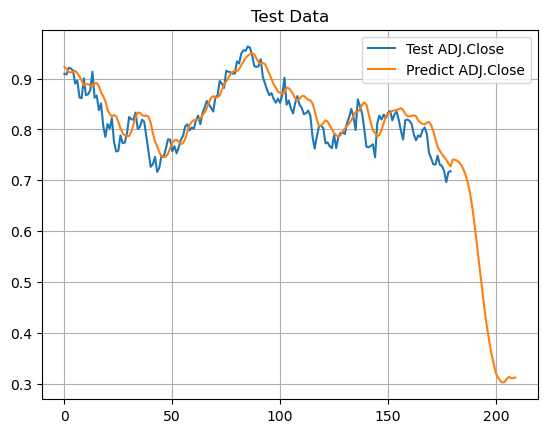

In [30]:
predict = model.predict(testX)

plt.title("30 Days After")
plt.plot(testY[:, 4], label="Test ADJ.Close")
plt.plot(predict[:, 4], label="Predict ADJ.Close")
plt.grid(True)
plt.legend()
plt.show()